# Create AI API client in python

In [36]:
root_path = "/Users/I559573/Library/CloudStorage/OneDrive-SAPSE/Documents/D2V2.0_PREP/\
lgp_green_factory"

In [37]:
import sys, os
import json
from json import dumps
import requests
import base64
from base64 import b64encode, b64decode
import time
import yaml
from IPython.display import clear_output
from pprint import pprint
import ast
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
import cv2
import glob
import io


from ai_api_client_sdk.ai_api_v2_client import AIAPIV2Client
from ai_api_client_sdk.models.artifact import Artifact
from ai_api_client_sdk.models.status import Status
from ai_api_client_sdk.models.target_status import TargetStatus
from ai_api_client_sdk.models.parameter_binding import ParameterBinding
from ai_api_client_sdk.models.input_artifact_binding import InputArtifactBinding

In [38]:
resource_group = "defect-det-calabria" # Must be created before

aic_service_key = root_path + "/files/aic_service_key.json" # ENSURE YOU HAVE THE FILE PLACED CORRECTLY
with open(aic_service_key) as ask:
    aic_s_k = json.load(ask)

ai_api_v2_client = AIAPIV2Client(
    base_url=aic_s_k["serviceurls"]["AI_API_URL"] + "/v2/lm",
    auth_url=aic_s_k["url"] + "/oauth/token",
    client_id=aic_s_k['clientid'],
    client_secret=aic_s_k['clientsecret'],
    resource_group=resource_group)

# Train execution of ML Model

Create a training configuration

In [ ]:
# Load training_workflow.yaml
training_workflow_file = root_path + "/wf_seg_calabria/training_workflow_seg.yaml"
with open(training_workflow_file) as twf:
    training_workflow = yaml.safe_load(twf)
    
# Load scenario id from train_workflow.yaml
scenario_id = training_workflow['metadata']['labels']['scenarios.ai.sap.com/id']
    
artifact_id = 'artifact_id.json'
with open(artifact_id) as to:
    artifact_resp = json.load(to)

In [ ]:
input_artifact_name = training_workflow['spec']['templates'][0]['inputs']['artifacts'][0]['name']
executable_name = training_workflow['metadata']['name']

artifact_binding = {
    "key": input_artifact_name,
    "artifact_id": artifact_resp['id']
}

train_configuration = {
    "name": "dev-tutorial-training-configuration",
    "scenario_id": scenario_id,
    "executable_id": executable_name,
    "parameter_bindings": [],
    "input_artifact_bindings": [ InputArtifactBinding(**artifact_binding) ]
}

# store the configuration response to access the id to create an execution
train_config_resp = ai_api_v2_client.configuration.create(**train_configuration)
pprint(vars(train_config_resp))

assert train_config_resp.message == 'Configuration created'

print("Configuration created for running the training")

Create a training execution

In [ ]:
execution_resp = ai_api_v2_client.execution.create(train_config_resp.id)
pprint(vars(execution_resp))

Observe the training status

In [ ]:
status = None
while status != Status.COMPLETED and status != Status.DEAD:
    # Sleep for 5 secs to avoid overwhelming the API with requests
    time.sleep(5)
    # Clear outputs to reduce clutter
    clear_output(wait=True)

    execution = ai_api_v2_client.execution.get(execution_resp.id)
    status = execution.status
    print('...... execution status ......', flush=True)
    print(f"Training status: {execution.status}")
    pprint(f"Training status details: {execution.status_details}")

if execution.status == Status.COMPLETED:
    print(f"Training complete for execution [{execution_resp.id}]!")
    output_artifact = execution.output_artifacts[0]
    output = {
        "id": output_artifact.id,
        "name": output_artifact.name,
        "url": output_artifact.url
    }
    with open('training_output.json', 'w') as fp: #Save the reference to the model stored in S3
        json.dump(output, fp)

# Metrics and performance

In [ ]:
filter_string = "executionId eq '" + execution_resp.id + "'"
metric_resp = ai_api_v2_client.metrics.query(execution_ids=execution_resp.id)

for m in metric_resp.resources:
    for metric in m.metrics:
        print(metric.name)
        print(metric.value)

In [ ]:
all_metrics = []
for m in metric_resp.resources:
    for custom_info in m.custom_info:
        #print(custom_info.name)
        #print(custom_info.value)
        all_metrics.append(custom_info.value)

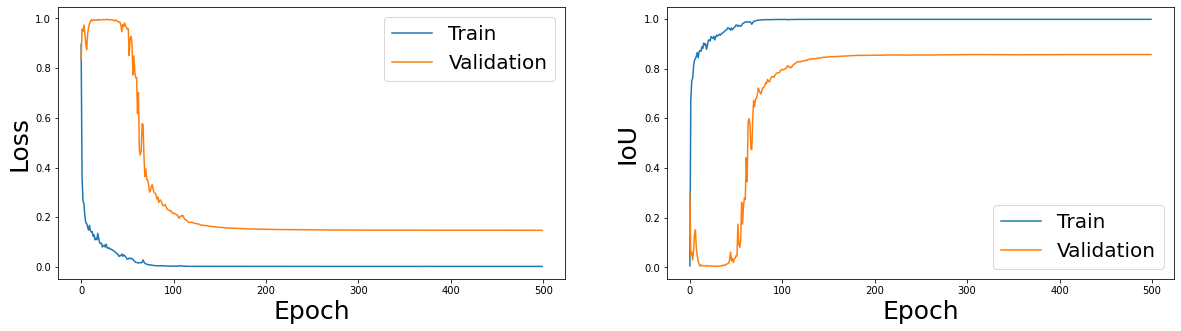

In [71]:
training_metrics = ast.literal_eval(all_metrics[0])
fig, axs = plt.subplots(1, 2, figsize=(20,5))

a = ast.literal_eval(training_metrics[0].get("loss"))
b = ast.literal_eval(training_metrics[1].get("val_loss"))
c = ast.literal_eval(training_metrics[2].get("iou"))
d = ast.literal_eval(training_metrics[3].get("val_iou"))

axs[0].plot(a)
axs[0].plot(b)
#axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Validation'], prop={'size': 20})

axs[1].plot(c)
axs[1].plot(d)
#axs[1].title.set_text('Training IoU vs Validation IoU')
axs[1].legend(['Train', 'Validation'], prop={'size': 20})

e=axs[0].set_xlabel('Epoch',fontsize=25)
e=axs[0].set_ylabel('Loss',fontsize=25)
e=axs[1].set_xlabel('Epoch',fontsize=25)
e=axs[1].set_ylabel('IoU',fontsize=25)

# Deploy ML Model

In [ ]:
serving_workflow_file = root_path + "/wf_seg_calabria/serving_workflow_seg.yaml"
with open(serving_workflow_file) as swf:
    serving_workflow = yaml.safe_load(swf)

scenario_id = serving_workflow['metadata']['labels']['scenarios.ai.sap.com/id']
input_artifact_name = serving_workflow['spec']['inputs']['artifacts'][0]['name']
executable_name = serving_workflow['metadata']['name']

training_output = 'training_output.json'
with open(training_output) as to:
    serving_input = json.load(to)

In [ ]:
artifact_binding = {
    "key": input_artifact_name,
    "artifact_id": serving_input["id"]
}

serve_configuration = {
    "name": "dev-tutorial-serving-configuration",
    "scenario_id": scenario_id,
    "executable_id": executable_name,
    "parameter_bindings": [],
    "input_artifact_bindings": [ InputArtifactBinding(**artifact_binding) ]
}

serve_config_resp = ai_api_v2_client.configuration.create(**serve_configuration)

assert serve_config_resp.message == 'Configuration created'

pprint(vars(serve_config_resp))
print("configuration for serving the model created")

In [40]:
deployment_resp = ai_api_v2_client.deployment.create(serve_config_resp.id)
pprint(vars(deployment_resp))

{'deployment_url': '',
 'id': 'd1a08e03229179a1',
 'message': 'Deployment scheduled.',
 'status': <Status.UNKNOWN: 'UNKNOWN'>}


In [41]:
# Poll deployment status
status = None
while status != Status.RUNNING and status != Status.DEAD:
    time.sleep(5)
    clear_output(wait=True)
    deployment = ai_api_v2_client.deployment.get(deployment_resp.id)
    status = deployment.status
    print('...... deployment status ......', flush=True)
    print(deployment.status)
    pprint(deployment.status_details)

    if deployment.status == Status.RUNNING:
        print(f"Deployment with {deployment_resp.id} complete!")

# Allow some time for deployment URL to get ready
time.sleep(10)

...... deployment status ......
Status.RUNNING
None
Deployment with d1a08e03229179a1 complete!


# Using deployed ML model

Let's define the local path to the dataset:

In [29]:
path_normal_images = sorted(glob.glob("../data/Images/OK/*"))
path_abnormal_images = sorted(glob.glob("../data/Images/NG/*"))
path_normal_masks = sorted(glob.glob("../data/Masks/OK_MSK/*"))
path_abnormal_masks = sorted(glob.glob("../data/Masks/NG_MSK/*"))

First let's visualize an example:

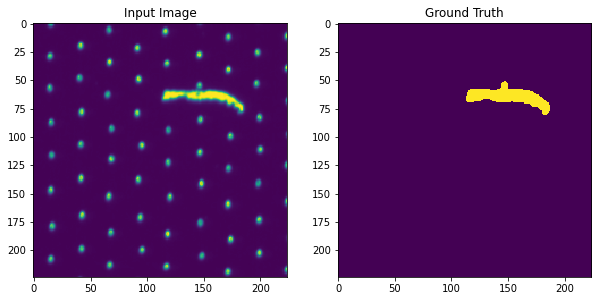

In [30]:
i = 0
fig, axs = plt.subplots(1, 2, figsize=(10,10))
title = ['Input Image', 'Ground Truth', 'Predicted Mask']
axs[0].title.set_text(title[0])
axs[0].imshow(mpimg.imread(path_abnormal_images[i]), interpolation='nearest')
axs[1].title.set_text(title[1])
axs[1].imshow(mpimg.imread(path_abnormal_masks[i]), interpolation='nearest')

In order to perform the inference step, let's transform one of the images into a binary string (this will constitute the body of the API call):

In [31]:
ENCODING = 'utf-8'

# first: reading the binary stuff
# note the 'rb' flag
# result: bytes
with open(path_abnormal_images[0], 'rb') as open_file:
    byte_content = open_file.read()

# second: base64 encode read data
# result: bytes (again)
base64_bytes = b64encode(byte_content)

# third: decode these bytes to text
# result: string (in utf-8)
base64_string = base64_bytes.decode(ENCODING)

# optional: doing stuff with the data
# result here: some dict
raw_data = {"image": base64_string}

In [32]:
# Preparing the input for inference
# prediciton: normal product

endpoint = f"{deployment.deployment_url}/v1/models/imagesegmodel:predict"
print(endpoint)

headers = {
        "Authorization": ai_api_v2_client.rest_client.get_token(),
        'ai-resource-group': resource_group,
        "Content-Type": "application/json"}
response = requests.post(endpoint, headers=headers, json=raw_data)

print('Inference result:', response.json())
#pprint(vars(response))

https://api.ai.prod.us-east-1.aws.ml.hana.ondemand.com/v2/inference/deployments/d974519436ad8dc3/v1/models/imagesegmodel:predict
Inference result: {'defected_area': '0.01823580994897959', 'segmented_image': 'Qk02yAAAAAAAADYEAAAoAAAA4AAAAOAAAAABAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEBAQACAgIAAwMDAAQEBAAFBQUABgYGAAcHBwAICAgACQkJAAoKCgALCwsADAwMAA0NDQAODg4ADw8PABAQEAAREREAEhISABMTEwAUFBQAFRUVABYWFgAXFxcAGBgYABkZGQAaGhoAGxsbABwcHAAdHR0AHh4eAB8fHwAgICAAISEhACIiIgAjIyMAJCQkACUlJQAmJiYAJycnACgoKAApKSkAKioqACsrKwAsLCwALS0tAC4uLgAvLy8AMDAwADExMQAyMjIAMzMzADQ0NAA1NTUANjY2ADc3NwA4ODgAOTk5ADo6OgA7OzsAPDw8AD09PQA+Pj4APz8/AEBAQABBQUEAQkJCAENDQwBEREQARUVFAEZGRgBHR0cASEhIAElJSQBKSkoAS0tLAExMTABNTU0ATk5OAE9PTwBQUFAAUVFRAFJSUgBTU1MAVFRUAFVVVQBWVlYAV1dXAFhYWABZWVkAWlpaAFtbWwBcXFwAXV1dAF5eXgBfX18AYGBgAGFhYQBiYmIAY2NjAGRkZABlZWUAZmZmAGdnZwBoaGgAaWlpAGpqagBra2sAbGxsAG1tbQBubm4Ab29vAHBwcABxcXEAcnJyAHNzcwB0dHQAdXV1AHZ2dgB3d3cAeHh4AHl5eQB6enoAe3t7AHx8fAB9fX0Afn5+AH9/fwCAgIAAgYGBAIKCggCDg4MAhISEAIWFhQCGhoYA

Let's decode the prediction and let's visualize it:

In [33]:
def load_image(data, IMG_WIDTH, IMG_HEIGHT, preproc):
    image = cv2.imdecode(data, 0)
    if preproc:
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        kernel = np.ones((3,3),np.uint8)
        image = cv2.dilate(image,kernel,iterations = 1)
        # go back to 3 channels
        image=np.expand_dims(image, axis=-1)
        image = image.repeat(3,axis=-1)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
    image = np.array(image)
    image = image.astype('float32')
    image /= 255
    return image

In [34]:
image_file_as_binary = base64.b64decode(response.json()['segmented_image'])
nparr = np.frombuffer(image_file_as_binary, np.uint8)
x_inference = load_image(nparr, 224, 224, False)

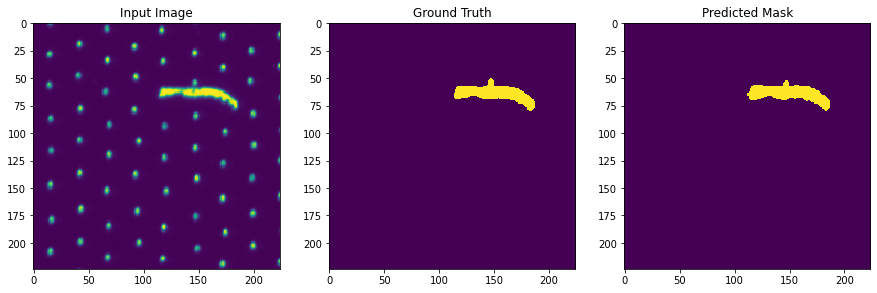

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15,20))
title = ['Input Image', 'Ground Truth', 'Predicted Mask']
axs[0].title.set_text(title[0])
axs[0].imshow(mpimg.imread(path_abnormal_images[i]), interpolation='nearest')
axs[1].title.set_text(title[1])
axs[1].imshow(mpimg.imread(path_abnormal_masks[i]), interpolation='nearest')
axs[2].title.set_text(title[2])
axs[2].imshow(x_inference, interpolation='nearest')

# Stop deployed model

In [ ]:
delete_resp = ai_api_v2_client.deployment.modify(deployment_resp.id, target_status=TargetStatus.STOPPED)

status = None
while status != Status.STOPPED:
    time.sleep(5)
    clear_output(wait=True)
    deployment = ai_api_v2_client.deployment.get(deployment_resp.id)
    status = deployment.status
    print('...... killing deployment ......', flush=True)
    print(f"Deployment status: {deployment.status}")